# Tools 2 Final Project

## Denver Airbnb Analysis


Jen Lee, Connie Chang

In [1]:
import pandas as pd
import geopandas as gpd
import re
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

## Data Gathering

#### Airbnb Data

Source: http://insideairbnb.com/get-the-data.html

|Date Compiled |County/City|File Name   |Description |
|:-------------|:---------:|:----------:|-----------:|
|29 March, 2021|Denver     |listings.csv|Summary information and metrics for listings in Denver (good for visualisations).|
|29 March, 2021|Denver     |reviews.csv|Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing).|
|N/A|Denver     |neighbourhoods.csv| Neighbourhood list for geo filter. Sourced from city or open source GIS files.|
|N/A|Denver     |neighbourhoods.geojson| GeoJSON file of neighbourhoods of the city.|

#### Other Data

|Source |File Name   |Description | URL |
|:-------------|:---------:|:----------:|-----------:|
|Wikipedia|neighbourhoods_den.csv   |Groups the Denver Neighbourhoods into Areas| https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Denver |



In [2]:
# listings.csv
listings = pd.read_csv("./data/denver_03_29_2021/listings.csv")
print(f"listings shape: {listings.shape}")
listings.sample(3)

listings shape: (3394, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1009,23170491,https://www.airbnb.com/rooms/23170491,20210329150448,2021-03-30,Tess and Alem ( LICENCE # 2018-BFN-0000730),License #2018-BFN-0000730<br />This beautiful ...,Very quite and beautiful neighbourhood.,https://a0.muscache.com/pictures/6ba3ea5e-a5d2...,23123101,https://www.airbnb.com/users/show/23123101,Tesfahun,2014-10-29,"Denver, Colorado, United States","friendly ,love listen gospel song ,reading boo...",within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/20675...,https://a0.muscache.com/im/pictures/user/20675...,Gateway / Green Valley Ranch,1.0,1.0,"['email', 'phone']",t,f,"Denver, Colorado, United States",Gateway - Green Valley Ranch,NaN,39.78275,-104.74836,Private room in house,Private room,5,NaN,1 private bath,2.0,2.0,"[""Wifi"", ""High chair"", ""Kitchen"", ""Carbon mono...",$71.00,3,30,3,3,30,30,3.0,30.0,NaN,t,13,38,65,160,2021-03-30,38,11,2,2018-02-25,2021-03-22,88.0,9.0,9.0,9.0,10.0,9.0,9.0,2018-BFN-0000730,f,1,0,1,0,1.01
1372,29417411,https://www.airbnb.com/rooms/29417411,20210329150448,2021-03-30,Located Centrally in Denver Metro area,The house is located 4 miles from downtown Den...,NaN,https://a0.muscache.com/pictures/45b2e559-6965...,37332028,https://www.airbnb.com/users/show/37332028,Timothy,2015-07-02,"Denver, Colorado, United States",I am a gay male professional in Denver. I have...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/37332028/prof...,https://a0.muscache.com/im/users/37332028/prof...,Valverde,1.0,1.0,"['email', 'phone', 'offline_government_id', 's...",t,t,NaN,Valverde,NaN,39.71970,-105.02050,Private room in house,Private room,1,NaN,1 private bath,1.0,1.0,"[""Washer"", ""Dedicated workspace"", ""Wifi"", ""Pri...",$27.00,30,1125,30,30,1125,1125,30.0,1125.0,NaN,t,21,51,81,261,2021-03-30,8,4,0,2018-11-26,2020-12-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,t,1,0,1,0,0.28
1241,27314379,https://www.airbnb.com/rooms/27314379,20210329150448,2021-03-31,Sanctuary In The City - Rumi Room,Sanctuary in the City is only 9 minutes from D...,This quiet neighborhood is surrounded by some ...,https://a0.muscache.com/pictures/cab6bf7c-d1eb...,29281163,https://www.airbnb.com/users/show/29281163,Shelly,2015-03-13,"Denver, Colorado, United States",Sanctuary is defined as a sacred and protected...,within an hour,100%,98%,t,https://a0.muscache.com/im/pictures/user/9f4f0...,https://a0.muscache.com/im/pictures/user/9f4f0...,Valverde,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Denver, Colorado, United States",Valverde,NaN,39.71481,-105.02200,Private room in house,Private room,1,NaN,1 shared bath,1.0,1.0,"[""Wifi"", ""Breakfast"", ""Kitchen"", ""Carbon monox...",$38.00,2,1125,2,2,1125,1125

In [3]:
# reviews.csv
reviews = pd.read_csv("./data/denver_03_29_2021/reviews.csv")
reviews.sample(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
22887,5794938,266240098,2018-05-19,5230409,Hillary,"This place is a gem, and Allan is a great host..."
172684,38953447,543899232,2019-10-08,263569821,Makaya,We had a great time at Dan’s place! We felt ve...
11046,2467260,357810288,2018-12-11,46043691,Christian,Ryan’s place was perfect for our trip. The spa...


In [4]:
# neighbourhoods.csv
neighborhoods = pd.read_csv("./data/denver_03_29_2021/neighbourhoods.csv")
neighborhoods.sample(3)

,neighbourhood_group,neighbourhood
39,NaN,Kennedy
7,NaN,Berkeley
19,NaN,Congress Park


In [5]:
# neighbourhoods.geojson
neighborhoods_gdf = gpd.read_file("./data/denver_03_29_2021/neighbourhoods.geojson")
neighborhoods_gdf.sample(3)

,neighbourhood,neighbourhood_group,geometry
1,Sunnyside,None,"MULTIPOLYGON (((-104.99818 39.78256, -104.9982..."
77,Montbello,None,"MULTIPOLYGON (((-104.80990 39.77283, -104.8192..."
31,Fort Logan,None,"MULTIPOLYGON (((-105.03462 39.65328, -105.0346..."


In [6]:
# neighbourhoods_den.csv
neighbourhoods_group = pd.read_csv("./data/neighbourhoods_den.csv")
neighbourhoods_group.sample(3)

,neighbourhood_cleansed,neighbourhood_group
69,Athmar Park,West
51,Platt Park,South
28,Elyria Swansea,North


## Data Cleaning

In [7]:
# remove unneeded columns from listings 
listings.drop(columns=["picture_url", "host_url", "host_thumbnail_url", "host_picture_url", "license", 'scrape_id', 
               'listing_url','last_scraped', 'neighborhood_overview','host_verifications' ,
               'host_about', 'host_thumbnail_url','host_neighbourhood', 'neighbourhood', 'name',
               'description','host_name', 'calendar_last_scraped'], axis=1, inplace=True)

In [8]:
# Clean up the "bathrooms_text" column to make two new columns - number of bathrooms, and a boolean column to indicate if bthrooms are private
def get_bathrooms_num(x):
    if type(x) != str:
        return 0.0
    elif x == "Shared half-bath" or x == "Half-bath":
        return 0.5
    elif "shared bath" in x:
        return float(x.strip("s").strip("shared bath"))
    elif "private bath" in x:
        return float(x.strip("s").strip("private bath"))
    elif "bath" in x:
        return float(x.strip("s").strip("bath"))
    else:
        return 0.0
    
# Returns "t" & "f" beacuse that's how the other booleans are formatted
def get_is_private_bathroom(x):
    if type(x) != str:
        return np.NaN
    elif "shared" in x:
        return "f"
    else:
        return "t"

listings["bathrooms"] = listings["bathrooms_text"].apply(lambda x: get_bathrooms_num(x))
listings["private_bathroom"] = listings["bathrooms_text"].apply(lambda x: get_is_private_bathroom(x))
listings = listings.drop("bathrooms_text", axis=1)

In [9]:
# Convert the latitude & longitude values to Point() values, to be used later for plotting
listings["coordinates"] = [Point(xy) for xy in zip(listings.longitude, listings.latitude)]

In [10]:
# For amenities. We want to explode that array out and convert the types of amenity to a "t/f" column showing if they have that amenity

all_amenities = set()

# First build an array of all the amenity types
for index, row in listings.iterrows():
    # Convert String representation of list to a list
    amenities = row["amenities"].replace('"', '').strip('][').split(', ')
    for item in amenities:
        all_amenities.add(item)
    
all_amenities

{'1 space',
 '120\\ HDTV with Netflix',
 '2 burner stovetop electric stove',
 '2 spaces',
 '2-5 years old',
 '30\\ HDTV with Netflix',
 '30\\ HDTV with Roku',
 '32\\ HDTV with Amazon Prime Video',
 '32\\ HDTV with Apple TV',
 '32\\ HDTV with Netflix',
 '32\\ HDTV with premium cable',
 '36\\ HDTV with Netflix',
 '37\\ TV',
 '4-burner cooktop (above microwave) electric stove',
 '40\\ HDTV',
 '40\\ HDTV with Amazon Prime Video',
 '40\\ HDTV with Chromecast',
 '40\\ HDTV with Netflix',
 '40\\ HDTV with standard cable',
 '40\\ TV',
 '40\\ TV with Roku',
 '41\\ TV with Chromecast',
 '42\\ HDTV with Amazon Prime Video',
 '42\\ HDTV with HBO Max',
 '42\\ TV',
 '43\\ HDTV with Amazon Prime Video',
 '44\\ HDTV with Netflix',
 '45\\ HDTV with Amazon Prime Video',
 '45\\ HDTV with HBO Max',
 '46\\ HDTV with Amazon Prime Video',
 '46\\ HDTV with Netflix',
 '48\\ HDTV with standard cable',
 '49\\ HDTV with Roku',
 '5-10 years old',
 '50\\ HDTV with Amazon Prime Video',
 '50\\ HDTV with Netflix',
 '5

In [11]:
## oof, that's a lot of ameneites, lets try to simple it down by hand
amenities = ["Air conditioning", "BBQ grill", "Baby bath", "Baby monitor", "Baby safety gates", "Backyard", 
             "Beachfront", "Bidet", "Bikes", "Board games", "Breakfast", "Cable", "Coffee", "Crib", "Dishwasher", "Dryer",
             "Fire pit", "Free parking", "Free wifi", "Game console", "Gym", "HGTV", "Heating", "High chair", 
            "Hot tub", "Luggage dropoff allowed", "Netflix", "Pets allowed", "Piano", "Ping pong table", "Pool", 
             "Pool table", "private entrance", "Private gym", "Private pool", "Private sauna", "Sauna",
             "Shared hot tub", "Shared outdoor heated pool", "Shared outdoor heated rooftop pool", "Shared outdoor pool",
            "Shared pool", "Shared sauna", "TV", "Washer", "Wifi", "Window AC unit"]


# Because a lot of these amenities have multiple similar forms, we'll check for them recursively
def check_for_amenity(amenities_str, amenity_to_check_for):
    amenities_list = amenities_str.replace('"', '').strip('][').split(', ')
    # convert list to lower so it's easer to check
    amenities_list = [each_string.lower() for each_string in amenities_list]
    for al in amenities_list:
        if amenity_to_check_for.lower() in al:
            # Check for pool & pool table seperate so those are very different
            if amenity_to_check_for.lower() == "pool":
                if "pool table" in al:
                    return "f"
                return "t"
            return "t"
    return "f"

# Now create column for each amenity
for a in amenities:
    listings[a] = listings["amenities"].apply(lambda al: check_for_amenity(al, a))
            
listings = listings.drop("amenities", axis = 1)
listings[amenities].sample(3)

,Air conditioning,BBQ grill,Baby bath,Baby monitor,Baby safety gates,Backyard,Beachfront,Bidet,Bikes,Board games,Breakfast,Cable,Coffee,Crib,Dishwasher,Dryer,Fire pit,Free parking,Free wifi,Game console,Gym,HGTV,Heating,High chair,Hot tub,Luggage dropoff allowed,Netflix,Pets allowed,Piano,Ping pong table,Pool,Pool table,private entrance,Private gym,Private pool,Private sauna,Sauna,Shared hot tub,Shared outdoor heated pool,Shared outdoor heated rooftop pool,Shared outdoor pool,Shared pool,Shared sauna,TV,Washer,Wifi,Window AC unit
715,t,f,f,f,f,t,f,f,f,f,f,t,t,f,t,t,f,f,f,f,f,f,t,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,t,t,f
2197,t,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,t,f,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,f,f,f,f,f,f,t,f
895,t,f,f,f,f,f,f,f,f,f,f,t,t,f,f,t,f,f,f,f,f,f,t,f,f,t,f,f,f,f,f,f,t,f,f,f,f,f,f,f,f,f,f,t,t,t,f


### Add neighbourhoods_group

In [12]:
# Merge neighbourhoods_group df into listings
listings = pd.merge(listings, neighbourhoods_group, on='neighbourhood_cleansed',  
         how='left', validate='m:1')

listings[['neighbourhood_cleansed','neighbourhood_group']].sample(5)

,neighbourhood_cleansed,neighbourhood_group
1246,University,South
2298,Sloan Lake,Northwest
2982,West Highland,Northwest
2849,Five Points,North
322,Baker,Central


### Price Field
'price' field is with type: object. It needs to remove '$' and ',' then convert to numeric.

In [13]:
print(f"listing price initial type: {listings.price.dtype}")

# drop the record with price = 0
listings = listings[listings['price']!='$0.00']

# remove '$' and ','
listings['price'] = listings['price'].str.strip('$')
listings['price'] = listings['price'].str.replace(',', '')

# convert to numeric
listings['price'] = pd.to_numeric(listings['price'])

print(f"listing price after cleaning type: {listings.price.dtype}")

listings['price'].describe()

listing price initial type: object
listing price after cleaning type: float64


count    3393.000000
mean      157.756263
std       244.777158
min        22.000000
25%        79.000000
50%       115.000000
75%       175.000000
max      9999.000000
Name: price, dtype: float64

### Convert Data Types
1. Convert to numeric: ```host_response_rate``` and ```host_acceptance_rate``` are object, remove '%' and convert to numeric
2. Convert to Ordinal: ```host_since```, ```first_review```, ```last_review```

In [14]:
# Remove % sign and convert the data type to numeric
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str[:-1])
listings['host_acceptance_rate'] = pd.to_numeric(listings['host_acceptance_rate'].str[:-1])

# Datetime format:
listings.host_since = pd.to_datetime(listings.host_since, format='%Y-%m-%d')
listings.first_review = pd.to_datetime(listings.first_review, format='%Y-%m-%d')
listings.last_review = pd.to_datetime(listings.last_review, format='%Y-%m-%d')

# Fill NA with 03/29/2012 (date data was scraped since we know they were at least a host since then)
listings['host_since'] = listings['host_since'].fillna(pd.datetime(year=2021, month=3, day=29))
listings['first_review'] = listings['first_review'].fillna(pd.datetime(year=2021, month=3, day=29))
listings['last_review'] = listings['last_review'].fillna(pd.datetime(year=2021, month=3, day=29))

# To Ordinal
listings['host_since'] = listings['host_since'].apply(lambda x: x.toordinal())
listings['first_review'] = listings['first_review'].apply(lambda x: x.toordinal())
listings['last_review'] = listings['last_review'].apply(lambda x: x.toordinal())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  del sys.path[0]


### Fill in NA
1. ```Bedrooms``` field with blank are the ones that either a studio, or an open space without separate room as a bedroom, so we fill it with 0.
2. ```Beds``` field with blank typically means that the listing host missed the field. The main point of airbnb is bed, we'd assume they have at least 1 bed, so fill in the blank ones with 1.
3. ```Reviews_per_month``` field with blank means there's no review at all. Thus, the ```first_review``` and ```last_review``` fields are both blank. We'd fill the ```reviews_per_month``` with 0.
4. Fill numerical columns with mean. (process before modeling)
5. Fill categorical columns with 'missing'.

In [15]:
# FunctionTransformer for fill NA 
from sklearn.preprocessing import FunctionTransformer
def custom_transformation(df):
    df['bedrooms'].fillna(0, inplace=True)
    df['beds'].fillna(1, inplace=True)
    df['reviews_per_month'].fillna(0, inplace=True)

ft = FunctionTransformer(func=custom_transformation, validate=False)
ft.fit_transform(listings)

In [16]:
# Categorical columns :
# Drop coortinates then get any remaining columns
catFeatures = listings.drop(['coordinates'], axis=1).select_dtypes(include=['object']).columns
catFeatures

Index(['host_location', 'host_response_time', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type',
       'has_availability', 'instant_bookable', 'private_bathroom',
       'Air conditioning', 'BBQ grill', 'Baby bath', 'Baby monitor',
       'Baby safety gates', 'Backyard', 'Beachfront', 'Bidet', 'Bikes',
       'Board games', 'Breakfast', 'Cable', 'Coffee', 'Crib', 'Dishwasher',
       'Dryer', 'Fire pit', 'Free parking', 'Free wifi', 'Game console', 'Gym',
       'HGTV', 'Heating', 'High chair', 'Hot tub', 'Luggage dropoff allowed',
       'Netflix', 'Pets allowed', 'Piano', 'Ping pong table', 'Pool',
       'Pool table', 'private entrance', 'Private gym', 'Private pool',
       'Private sauna', 'Sauna', 'Shared hot tub',
       'Shared outdoor heated pool', 'Shared outdoor heated rooftop pool',
       'Shared outdoor pool', 'Shared pool', 'Shared sauna', 'TV', 'Washer',
       'Wifi', 'Window AC 

In [17]:
listings[catFeatures] = listings[catFeatures].fillna('missing') # fill categorical columns with 'missing'

### Dropping Any Remaining Data that can't be Cleaned
1. Drop all NA columns ```neighbourhood_group_cleansed```, ```calendar_updated```
2. There are 4 records with NA in the ```bathrooms_text``` field, which be previously convertyed to ```private_bathroom```.
3. Drop records with NA in ```host_identity_verified``` as these may not be verified to be trust worthy hosts.

In [18]:
listings.drop(['neighbourhood_group_cleansed','calendar_updated'], axis=1, inplace=True)

# drop records with host_verified na and private_bathroom na (no data from bathroom_text)
listings.dropna(subset=['private_bathroom'], inplace=True)
listings.dropna(subset=['host_identity_verified'], inplace=True)

In [19]:
print(f"after dropping listings df shape: {listings.shape}")
listings.info()

after dropping listings df shape: (3393, 103)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3393 entries, 0 to 3393
Columns: 103 entries, id to neighbourhood_group
dtypes: float64(20), int64(23), object(60)
memory usage: 2.7+ MB


In [20]:
listings.sample(3)

,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,...,Bikes,Board games,Breakfast,Cable,Coffee,Crib,Dishwasher,Dryer,Fire pit,Free parking,Free wifi,Game console,Gym,HGTV,Heating,High chair,Hot tub,Luggage dropoff allowed,Netflix,Pets allowed,Piano,Ping pong table,Pool,Pool table,private entrance,Private gym,Private pool,Private sauna,Sauna,Shared hot tub,Shared outdoor heated pool,Shared outdoor heated rooftop pool,Shared outdoor pool,Shared pool,Shared sauna,TV,Washer,Wifi,Window AC unit,neighbourhood_group
690,18105941,68217974,736075,"Denver, Colorado, United States",within an hour,100.0,96.0,t,3.0,3.0,t,t,Regis,39.78868,-105.04266,Private room in house,Private room,2,1.0,1.0,1.0,75.0,1,7,1,1,7,7,1.0,7.0,t,17,46,66,66,71,6,1,736484,737877,...,f,f,f,f,f,f,f,t,f,f,f,f,f,f,t,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,f,t,f,Northwest
1267,27663042,208115656,736913,"Denver, Colorado, United States",within a few hours,80.0,92.0,f,2.0,2.0,t,f,Gateway - Green Valley Ranch,39.78205,-104.73806,Private room in apartment,Private room,2,1.0,0.0,1.0,40.0,29,1111,29,29,1125,1125,29.0,1125.0,t,30,60,90,90,11,2,0,736920,737574,...,f,f,f,f,f,f,f,t,f,t,f,f,f,f,t,f,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,f,f,f,f,t,f,t,f,Northeast
1926,38621026,96032444,736227,"Denver, Colorado, United States",within an hour,100.0,89.0,t,2.0,2.0,t,t,Five Points,39.76203,-104.97608,Entire house,Entire home/apt,16,2.5,5.0,13.0,862.0,1,30,1,3,1125,1125,1.9,1125.0,t,14,31,48,292,8,8,4,737689,737864,...,f,f,f,f,t,t,t,t,f,t,f,t,t,f,t,t,t,t,f,f,f,f,t,f,t,f,f,f,f,f,f,f,f,f,f,t,t,t,f,North


## Visualizations

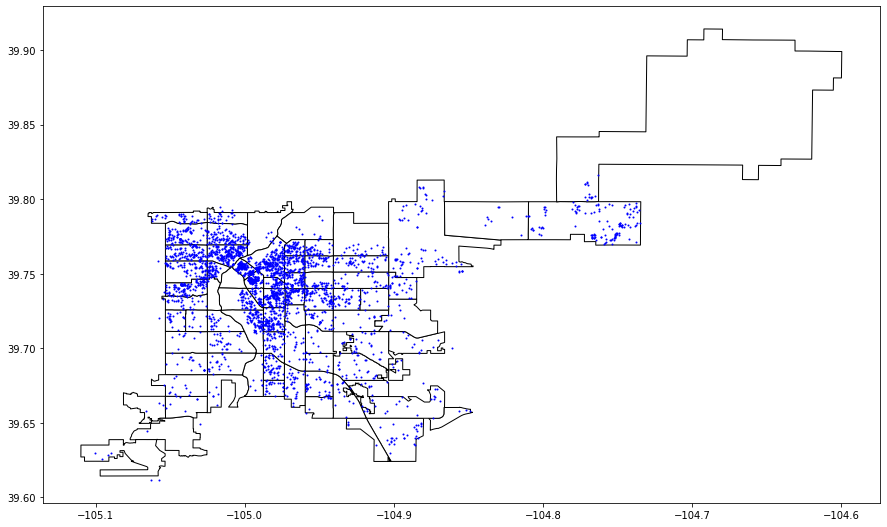

In [21]:
# Plot all the coordinates from the listings on the neighborhoods map
listings_gdf = gpd.GeoDataFrame(listings, geometry="coordinates")

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax = neighborhoods_gdf.plot(color="white", edgecolor="black", ax=ax)
listings_gdf.plot(ax=ax, color="blue", markersize=1)

plt.show()

[Text(0.5, 1.0, 'Listing distributions per Neighborhood Group')]

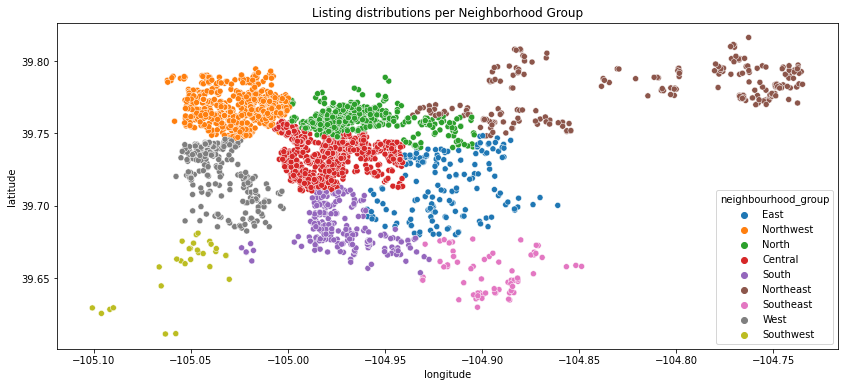

In [22]:
plt.figure(figsize=(14,6))

sns.scatterplot(data=listings, x='longitude', y='latitude', hue='neighbourhood_group').set(title='Listing distributions per Neighborhood Group')

### Listings Accomdiates

[Text(0.5, 1.0, 'Listings Accomdiates(Num of People)')]

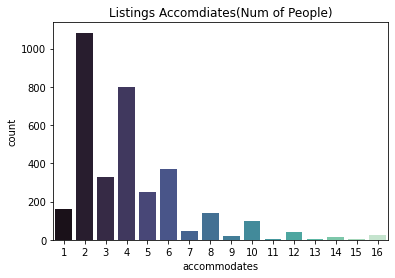

In [23]:
sns.countplot(x=listings.accommodates, palette="mako").set(title='Listings Accomdiates(Num of People)')

### Host Response Time

host_is_superhost,f,t
host_response_time,,
a few days or more,41.0,3.0
within a day,138.0,70.0
within a few hours,264.0,186.0
within an hour,939.0,1282.0


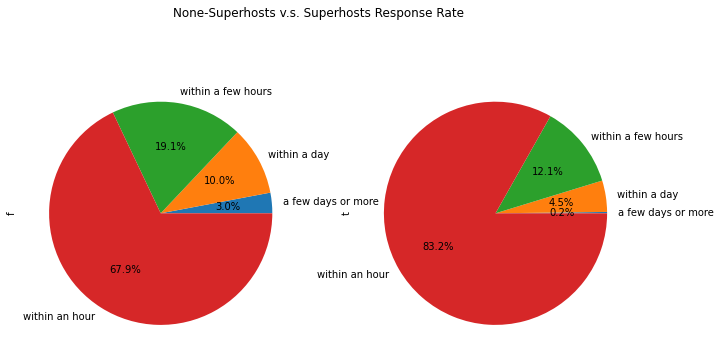

In [24]:
host_response =pd.DataFrame(listings.groupby('host_response_time')['host_is_superhost'].value_counts().unstack()).drop('missing', axis=1).drop('missing', axis=0)

host_response.plot.pie(subplots=True, figsize=(11, 6),
                 labels=host_response.index,legend=False, 
                 title='None-Superhosts v.s. Superhosts Response Rate',
                 autopct='%1.1f%%')
host_response

### Neighbourhood Group 

Text(0.5, 1.0, 'Listing Proportion by Neighbourhood_group')

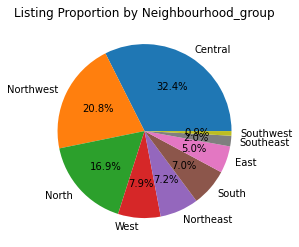

In [25]:
# pie chart to show listing proportion by neighbourhood group
plt.pie(listings.neighbourhood_group.value_counts(), 
        labels=listings.neighbourhood_group.value_counts().index, 
        autopct='%1.1f%%')

plt.title('Listing Proportion by Neighbourhood_group')

neighbourhood_group
Central      193921
Northwest    106023
North         89915
Northeast     40300
West          39398
South         36428
East          26858
Southeast      9792
Southwest      3936
Name: availability_365, dtype: int64

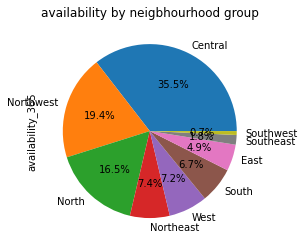

In [26]:
neighbourhoods_availability = listings.groupby('neighbourhood_group')['availability_365'].sum().sort_values(ascending=False)
neighbourhoods_availability.plot.pie(title='availability by neigbhourhood group', 
                                     labels=neighbourhoods_availability.index, autopct='%1.1f%%')

neighbourhoods_availability.sort_values(ascending=False)

### Listings Price

count    3393.000000
mean      157.756263
std       244.777158
min        22.000000
25%        79.000000
50%       115.000000
75%       175.000000
max      9999.000000
Name: price, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'listings Price Distribution')]

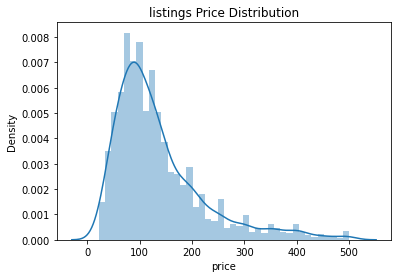

In [27]:
print(listings['price'].describe())
listings_price_500 = listings[listings['price']<=500]
sns.distplot(listings_price_500.price, kde=True).set(title = 'listings Price Distribution')

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Central,1072.00,136.69,76.88,29.00,82.75,119.00,171.00,499.00
East,164.00,111.23,74.98,23.00,64.75,81.00,140.25,408.00
North,552.00,138.89,89.69,29.00,80.00,116.00,164.00,495.00
Northeast,242.00,108.25,84.90,22.00,48.25,80.00,136.75,464.00
Northwest,682.00,148.87,92.00,25.00,90.00,120.00,179.00,499.00
South,232.00,129.44,82.78,25.00,75.00,106.00,150.00,485.00
Southeast,66.00,112.80,96.97,24.00,50.00,77.50,119.75,400.00
Southwest,28.00,127.18,102.63,29.00,69.50,86.50,143.00,416.00
West,262.00,138.46,90.33,24.00,75.00,119.50,176.75,450.00


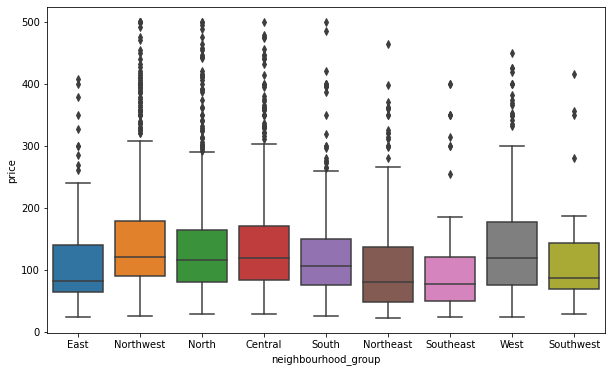

In [28]:
# Neighbourhood price box plot
plt.figure(figsize=(10,6))
sns.boxplot(y='price',x='neighbourhood_group', data = listings[listings['price']<=500])

pd.options.display.float_format = "{:.2f}".format
listings[listings['price']<500].groupby(['neighbourhood_group'])['price'].describe()

### Room Type

Entire home/apt   0.81
Private room      0.18
Hotel room        0.01
Shared room       0.01
Name: room_type, dtype: float64

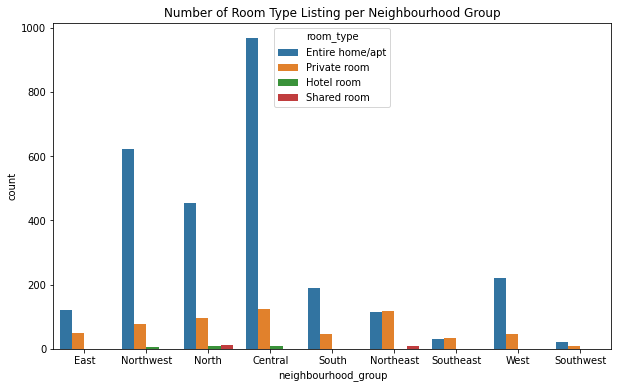

In [29]:
#Room Type by neighbourhood group
plt.figure(figsize=(10,6))
sns.countplot(x=listings.neighbourhood_group, hue=listings.room_type).set(title='Number of Room Type Listing per Neighbourhood Group')

# Room type proportion
listings.room_type.value_counts(normalize=True)

### Customer Reviews

In [30]:
# Reviews v.s. Listings in each neighbourhoods_group
neighbourhood_group_table = listings.groupby('neighbourhood_group')['number_of_reviews'].agg(['sum', 'count']).rename(columns={'count':'Total_Listings', 'sum': 'Total_Reviews'})
neighbourhood_group_table['Listings_w_Reviews'] = listings.groupby('neighbourhood_group')['number_of_reviews'].apply(lambda x: x[x>2].count())
neighbourhood_group_table['%_Listings_with_Reveiws'] = neighbourhood_group_table.Listings_w_Reviews/neighbourhood_group_table.Total_Listings
neighbourhood_group_table

,Total_Reviews,Total_Listings,Listings_w_Reviews,%_Listings_with_Reveiws
neighbourhood_group,,,,
Central,53076,1100,721,0.66
East,7849,170,129,0.76
North,43573,573,484,0.84
Northeast,13196,244,179,0.73
Northwest,42675,705,549,0.78
South,11875,237,183,0.77
Southeast,1883,67,42,0.63
Southwest,1527,29,21,0.72
West,11527,268,202,0.75


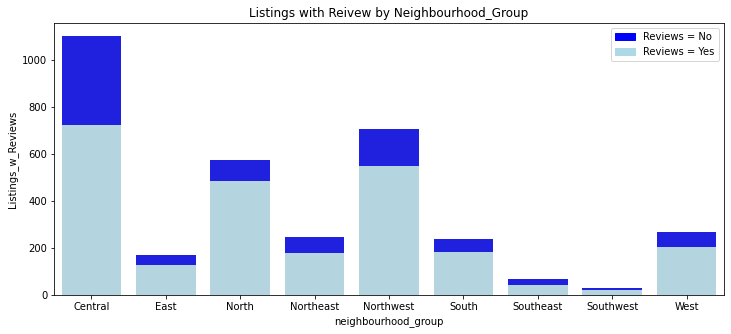

In [31]:
# plot listings with and without reviews by neighbourhoods_group
plt.figure(figsize=(12,5))
sns.barplot(data=neighbourhood_group_table, x=neighbourhood_group_table.index, y=neighbourhood_group_table.Total_Listings, color='blue')
sns.barplot(data=neighbourhood_group_table, x=neighbourhood_group_table.index, y=neighbourhood_group_table.Listings_w_Reviews, color='lightblue').set(title='Listings with Reivew by Neighbourhood_Group')

top_bar = mpatches.Patch(color='blue', label='Reviews = No')
bottom_bar = mpatches.Patch(color='lightblue', label='Reviews = Yes')
plt.legend(handles=[top_bar, bottom_bar])

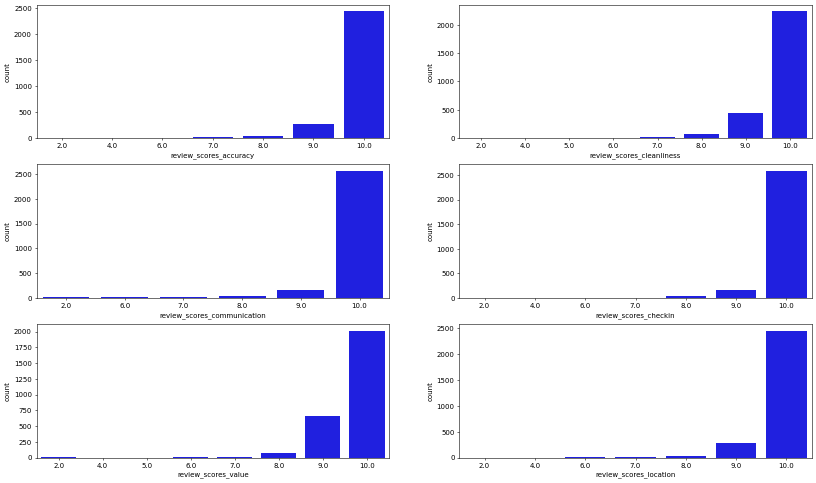

In [32]:
# Review Scores
fig, axs = plt.subplots(3, 2, figsize=(20, 12), dpi=50)

sns.countplot(x=listings["review_scores_accuracy"].dropna(),color='b', ax=axs[0, 0])
sns.countplot(x=listings["review_scores_cleanliness"].dropna(),color='b', ax=axs[0, 1])
sns.countplot(x=listings["review_scores_communication"].dropna(),color='b', ax=axs[1, 0])
sns.countplot(x=listings["review_scores_checkin"].dropna(),color='b', ax=axs[1, 1])
sns.countplot(x=listings["review_scores_value"].dropna(),color='b', ax=axs[2, 0])
sns.countplot(x=listings["review_scores_location"].dropna(),color='b', ax=axs[2, 1])

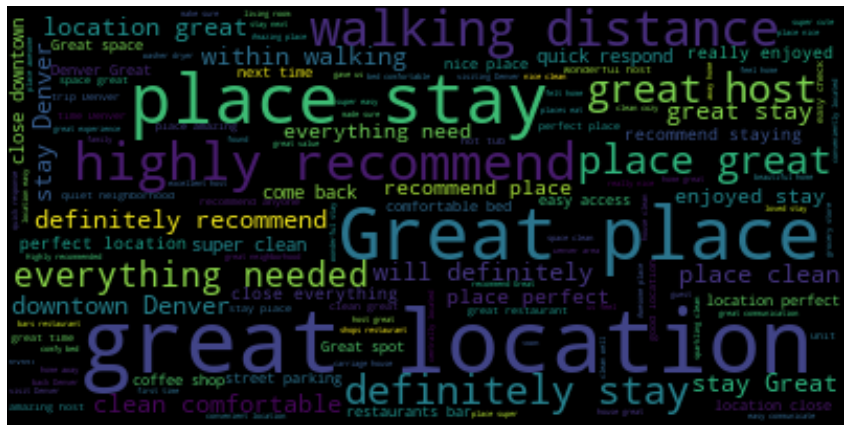

In [33]:
# make a word cloud with all the reviews text

# function to lump all the text together
def lumpText(text_array):
    lump = ""
    for i in text_array:
        lump += str(i) + " "
    return lump

# generate wordcloud
reviews_lump_text = lumpText(reviews["comments"].values)
reviews_wordcloud = WordCloud().generate(reviews_lump_text)

# plot
plt.figure(figsize=(15,10))
plt.imshow(reviews_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Fillna for numerical features for modeling

In [34]:
#Numeric columns :
numFeatures = listings.select_dtypes(include=['int64', 'float64']).columns
numFeatures

Index(['id', 'host_id', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private

In [35]:
listings[numFeatures] = listings[numFeatures].fillna(listings[numFeatures].mean()) # fill numberical columns with mean

# Model

### Convert Categoircal Features to Numberic with LabelEncoder()

In [36]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values
for cat in catFeatures:
    # Save neighbourhoog_group_mapping for later
    listings[cat] = labelencoder.fit_transform(listings[cat])
    if cat == 'neighbourhood_group':
        neighbourhood_group_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

listings[catFeatures].sample(3)

,host_location,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,has_availability,instant_bookable,private_bathroom,Air conditioning,BBQ grill,Baby bath,Baby monitor,Baby safety gates,Backyard,Beachfront,Bidet,Bikes,Board games,Breakfast,Cable,Coffee,Crib,Dishwasher,Dryer,Fire pit,Free parking,Free wifi,Game console,Gym,HGTV,Heating,High chair,Hot tub,Luggage dropoff allowed,Netflix,Pets allowed,Piano,Ping pong table,Pool,Pool table,private entrance,Private gym,Private pool,Private sauna,Sauna,Shared hot tub,Shared outdoor heated pool,Shared outdoor heated rooftop pool,Shared outdoor pool,Shared pool,Shared sauna,TV,Washer,Wifi,Window AC unit,neighbourhood_group
1529,119,4,0,2,2,20,22,2,1,1,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
1458,35,4,2,2,2,67,8,0,1,1,2,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,8
2331,35,4,2,2,2,54,8,0,1,0,2,1,1,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,2


### Splitting data into test train

In [37]:
from sklearn.model_selection import train_test_split

# Dependent variable: neighbourhood_group
y = listings['neighbourhood_group']

# Drop dependent variable and other variables that would tamper the results
X = listings.drop(['neighbourhood_group', 'id', 'host_id', 'neighbourhood_cleansed', 'coordinates', 'longitude', 'latitude'], axis=1)

In [38]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Fit Initial Model

In [39]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=50)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
y_pred = rf.predict(X_test)
y_pred

array([8, 0, 3, ..., 0, 2, 3])

## Model Evaluation

In [41]:
from sklearn import metrics

# First evaluate inital model to get a feel of the metrics
print('n_estimators = 50')
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators = 50
	Mean Absolute Error: 1.6719056974459725
	Mean Squared Error: 6.662082514734774
	Root Mean Squared Error: 2.5811010276110413


In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[245   1  19   2  52   0   0   0   0]
 [ 23   4   7   6  15   0   0   0   0]
 [ 64   0  57   2  51   2   0   0   1]
 [ 24   1   9  22  14   2   0   0   1]
 [ 61   4  29   0 113   2   0   0   5]
 [ 22   1  10   3  20   8   0   0   1]
 [ 13   0   0   3   3   0   3   0   2]
 [  4   0   0   0   8   0   0   1   1]
 [ 18   0  15   3  26   0   0   0  15]]
              precision    recall  f1-score   support

           0       0.52      0.77      0.62       319
           1       0.36      0.07      0.12        55
           2       0.39      0.32      0.35       177
           3       0.54      0.30      0.39        73
           4       0.37      0.53      0.44       214
           5       0.57      0.12      0.20        65
           6       1.00      0.12      0.22        24
           7       1.00      0.07      0.13        14
           8       0.58      0.19      0.29        77

    accuracy                           0.46      1018
   macro avg       0.59      0.28      0.31      101

In [43]:
# Make Evaluation Dataframe
evaluation = pd.DataFrame({'n_estimators': [],
                           'Mean Absolute Error':[],
                           'Mean Squared Error':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'Accuracy':[]})

# Make for loop to graph RMSE & Accuracy for different n_estimators
for i in range(5, 201, 5):
    # Make Classifier & Fit
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    # append to evaluation data frame
    r = evaluation.shape[0]
    evaluation.loc[r] = [i,mae,mse,rmse,accuracy]

In [44]:
# Show evaluation dataframe
evaluation.sample(3)

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
11,60.00,1.65,6.62,2.57,0.46
13,70.00,1.75,7.28,2.70,0.45
20,105.00,1.58,6.33,2.51,0.48


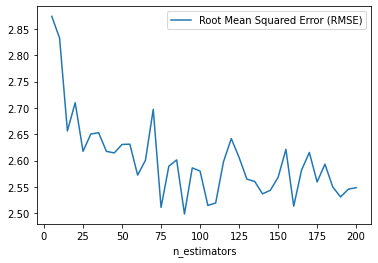

In [45]:
# Plot RMSE
evaluation.plot(kind='line',x='n_estimators',y='Root Mean Squared Error (RMSE)')

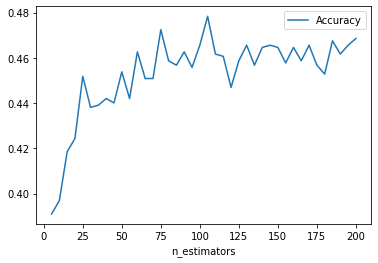

In [46]:
# Plot Accuracy
evaluation.plot(kind='line',x='n_estimators',y='Accuracy')

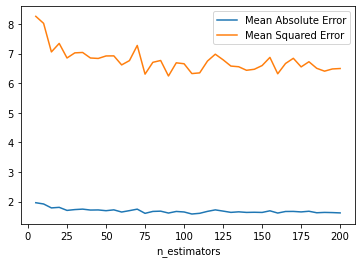

In [47]:
# Plot other Metrics
evaluation.plot(kind='line',x='n_estimators',y=['Mean Absolute Error', 'Mean Squared Error'])

## Model Selection

In [48]:
# Get row in dataframe where accuracy was the highest
best_model = evaluation.sort_values(by = "Accuracy", ascending = False).head(1)
best_model

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
20,105.00,1.58,6.33,2.51,0.48


In [49]:
best_n = int(best_model['n_estimators'].iloc[0])
print("We saw best performace on a RandomForestClassifier with n_estimators = ", best_n)

We saw best performace on a RandomForestClassifier with n_estimators =  105


In [50]:
# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=best_n)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=105,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
y_pred = rf.predict(X_test)
y_pred

array([4, 4, 3, ..., 0, 3, 3])

In [52]:
print('n_estimators = ', best_n)
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators =  105
	Mean Absolute Error: 1.6611001964636543
	Mean Squared Error: 6.739685658153242
	Root Mean Squared Error: 2.596090456465884


In [53]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Final Accuracy: ", accuracy_score(y_test, y_pred))

[[244   1  26   1  46   0   0   0   1]
 [ 27   1   5   5  17   0   0   0   0]
 [ 69   0  51   2  50   2   0   0   3]
 [ 14   0   8  27  23   0   0   0   1]
 [ 60   2  27   1 121   0   0   0   3]
 [ 24   0  12   2  19   8   0   0   0]
 [ 11   1   0   3   4   0   3   0   2]
 [  3   2   1   0   8   0   0   0   0]
 [ 21   0  14   2  25   0   0   0  15]]
              precision    recall  f1-score   support

           0       0.52      0.76      0.62       319
           1       0.14      0.02      0.03        55
           2       0.35      0.29      0.32       177
           3       0.63      0.37      0.47        73
           4       0.39      0.57      0.46       214
           5       0.80      0.12      0.21        65
           6       1.00      0.12      0.22        24
           7       0.00      0.00      0.00        14
           8       0.60      0.19      0.29        77

    accuracy                           0.46      1018
   macro avg       0.49      0.27      0.29      101

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
# Create DatFrame of Feature importance for our best model.
feature_importance1 = pd.DataFrame(rf.feature_importances_, X.columns)
feature_importance1.columns = ['importance1']
feature_importance1 = feature_importance1.sort_values(by = 'importance1', ascending = False)

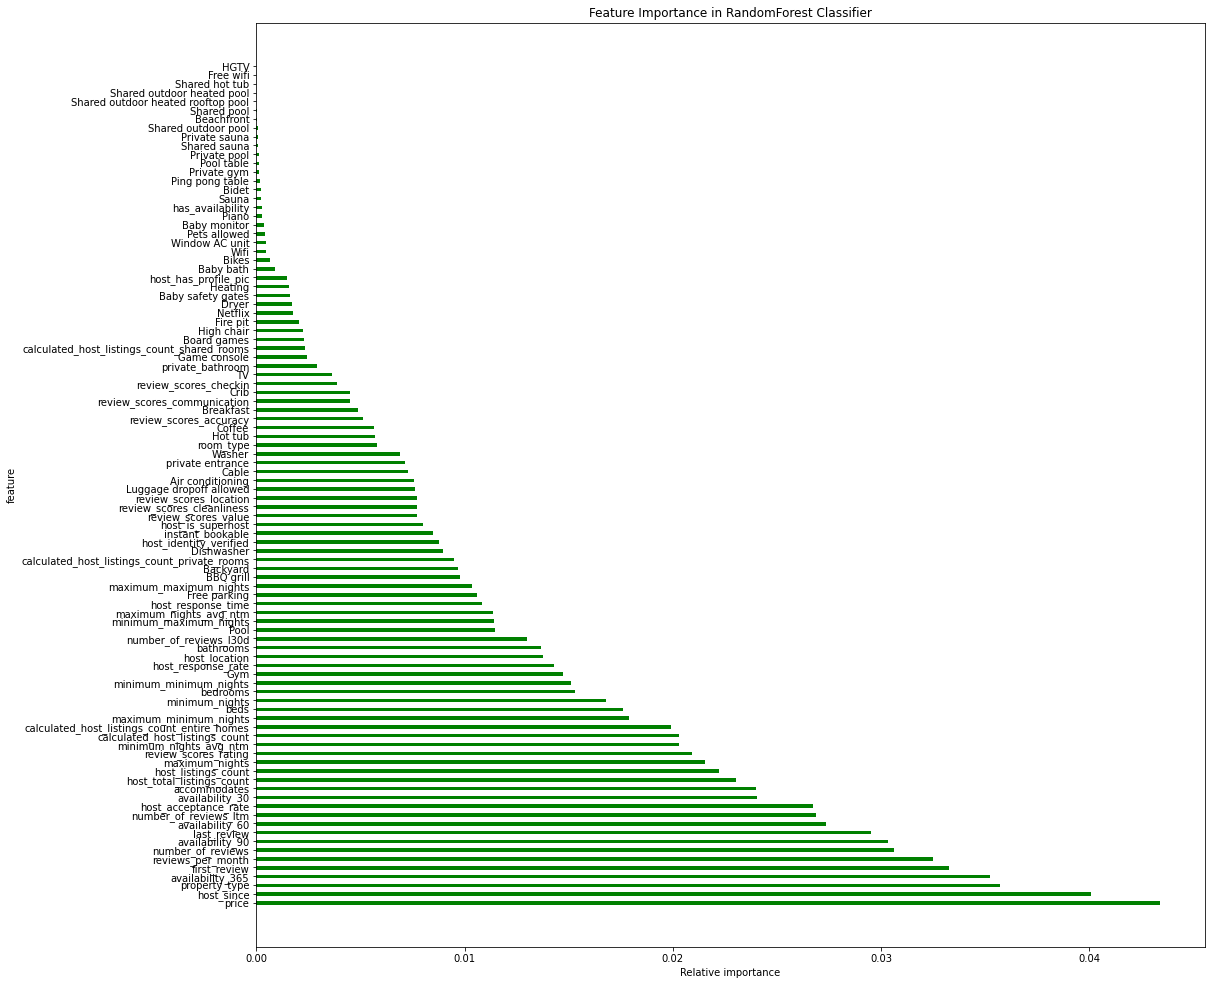

<Figure size 1224x1224 with 0 Axes>

In [55]:
col = feature_importance1.index
y = feature_importance1.importance1

# plot feature_importance
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature Importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(17,17))
fig.set_size_inches(17, 17, forward=True)

## Models with Iscolated Neighbourhoods

### Northwest, West, North

Because the highest accuracy we saw was still under 50% when choosing between 9 neighbourhoods groups. Lets try to iscolate it to 3 nighbourhoods. And since ```price``` was the most importance feature, lets use the ```neighbourhood_groups``` ```Northwest```, ```West```, & ```North``` because they had the highest mean prices, similar median prices, and are all next to each other.

In [56]:
# First we have to check out out categorical mapping from earlier to know what categories these neighbourhoods are in
neighbourhood_group_mapping

{'Central': 0,
 'East': 1,
 'North': 2,
 'Northeast': 3,
 'Northwest': 4,
 'South': 5,
 'Southeast': 6,
 'Southwest': 7,
 'West': 8}

In [57]:
listings_iso = listings.loc[listings["neighbourhood_group"].isin([neighbourhood_group_mapping["Northwest"], neighbourhood_group_mapping["West"], neighbourhood_group_mapping["North"]])]

# Dependent variable: neighbourhood_group
y = listings_iso['neighbourhood_group']

# Drop dependent variable and other variables that would tamper the results
X = listings_iso.drop(['neighbourhood_group', 'id', 'host_id', 'neighbourhood_cleansed', 'coordinates', 'longitude', 'latitude'], axis=1)

In [58]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Model Evaluation 

In [59]:
# Do same process as before where we find best n_estimator in a for loop
evaluation_iso = pd.DataFrame({'n_estimators': [],
                           'Mean Absolute Error':[],
                           'Mean Squared Error':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'Accuracy':[]})

# Make for loop to graph RMSE & Accuracy for different n_estimators
for i in range(5, 201, 5):
    # Make Classifier & Fit
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    # append to evaluation data frame
    r = evaluation_iso.shape[0]
    evaluation_iso.loc[r] = [i,mae,mse,rmse,accuracy]

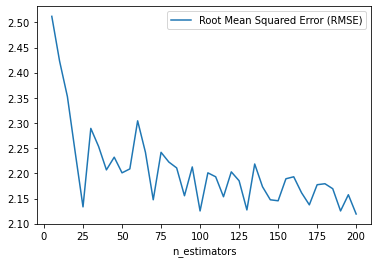

In [60]:
# Plot RMSE
evaluation_iso.plot(kind='line',x='n_estimators',y='Root Mean Squared Error (RMSE)')

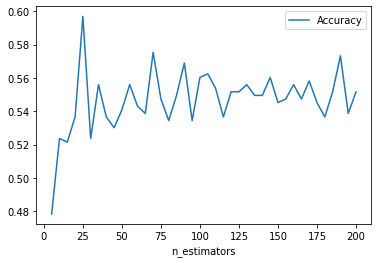

In [61]:
# Plot Accuracy
evaluation_iso.plot(kind='line',x='n_estimators',y='Accuracy')

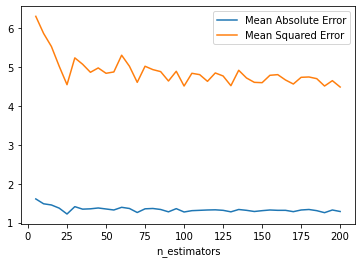

In [62]:
# Plot other Metrics
evaluation_iso.plot(kind='line',x='n_estimators',y=['Mean Absolute Error', 'Mean Squared Error'])

### Model Selection

In [63]:
# Get row in dataframe where accuracy was the highest
best_model_iso = evaluation_iso.sort_values(by = "Accuracy", ascending = False).head(1)
best_model_iso

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
4,25.00,1.22,4.55,2.13,0.60


In [64]:
best_n_iso = int(best_model_iso['n_estimators'].iloc[0])
print("We saw best performace on a RandomForestClassifier with n_estimators = ", best_n_iso)

We saw best performace on a RandomForestClassifier with n_estimators =  25


In [65]:
# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=best_n_iso)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [66]:
y_pred = rf.predict(X_test)
y_pred

array([4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 2, 8, 2, 4, 2, 4, 2, 2, 2, 4,
       4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 2, 2,
       4, 4, 4, 2, 2, 4, 2, 2, 4, 4, 4, 2, 4, 2, 4, 2, 4, 2, 2, 4, 4, 2,
       4, 4, 8, 2, 4, 4, 4, 2, 2, 2, 4, 4, 2, 4, 2, 4, 4, 4, 2, 2, 4, 2,
       8, 4, 2, 2, 2, 4, 4, 4, 8, 2, 2, 4, 4, 8, 4, 4, 4, 4, 4, 4, 2, 4,
       4, 4, 4, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 2, 2, 2,
       4, 4, 4, 2, 4, 4, 2, 2, 4, 2, 4, 4, 8, 2, 4, 4, 4, 4, 4, 4, 2, 4,
       4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 2, 2, 4, 4,
       4, 2, 4, 4, 2, 4, 2, 4, 4, 4, 2, 2, 2, 8, 2, 4, 4, 4, 4, 4, 4, 4,
       2, 4, 2, 4, 4, 4, 2, 4, 2, 4, 2, 4, 4, 2, 2, 4, 4, 4, 2, 2, 4, 4,
       2, 4, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 2, 2, 2, 8, 2, 4, 2, 2, 4, 2,
       2, 4, 2, 4, 4, 4, 4, 2, 4, 2, 2, 2, 4, 2, 2, 4, 2, 4, 4, 4, 4, 4,
       2, 4, 4, 4, 4, 4, 2, 2, 2, 2, 4, 4, 2, 2, 4, 2, 4, 2, 2, 2, 4, 4,
       4, 4, 4, 2, 4, 2, 2, 2, 4, 2, 4, 4, 4, 2, 2,

In [67]:
print('n_estimators = ', best_n_iso)
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators =  25
	Mean Absolute Error: 1.375
	Mean Squared Error: 5.232758620689655
	Root Mean Squared Error: 2.287522375997589


In [68]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Final Accuray: ", accuracy_score(y_test, y_pred))

[[ 90  85   3]
 [ 48 151   3]
 [ 31  39  14]]
              precision    recall  f1-score   support

           2       0.53      0.51      0.52       178
           4       0.55      0.75      0.63       202
           8       0.70      0.17      0.27        84

    accuracy                           0.55       464
   macro avg       0.59      0.47      0.47       464
weighted avg       0.57      0.55      0.52       464

Final Accuray:  0.5495689655172413


In [69]:
# Create DatFrame of Feature importance for our best model.
feature_importance2 = pd.DataFrame(rf.feature_importances_, X.columns)
feature_importance2.columns = ['importance2']
feature_importance2 = feature_importance2.sort_values(by = 'importance2', ascending = False)

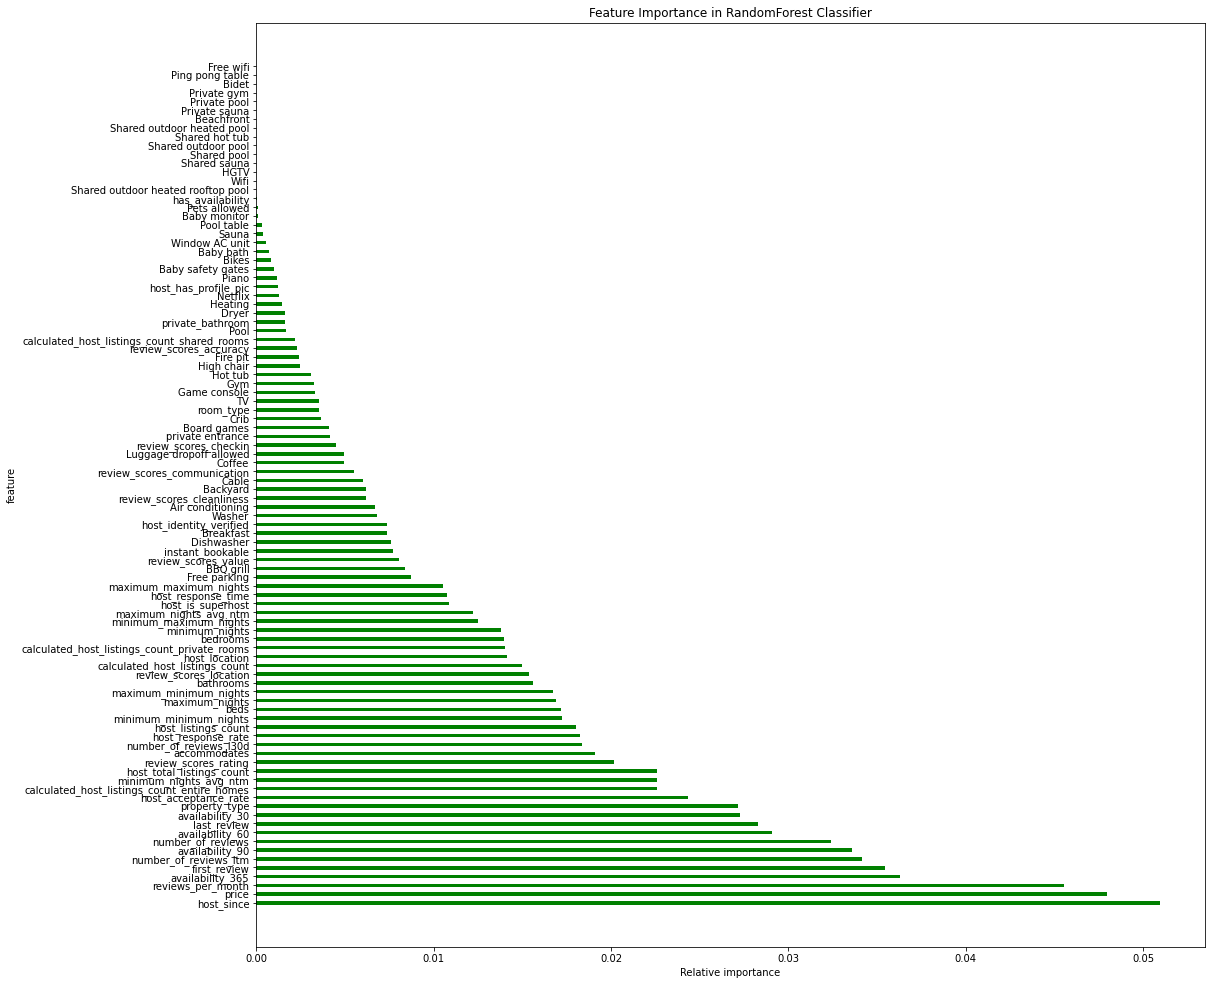

<Figure size 1224x1224 with 0 Axes>

In [70]:
col = feature_importance2.index
y = feature_importance2.importance2

# plot feature_importance
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature Importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(17,17))
fig.set_size_inches(17, 17, forward=True)

By isolating the neighbourhood groups the accuracy went up by over 10%! 

### Central, Northeast, Southwest

Now lets try running the model with ```neighbourhood_group```s that are further apart. 

In [71]:
listings_iso = listings.loc[listings["neighbourhood_group"].isin([neighbourhood_group_mapping["Central"], neighbourhood_group_mapping["Northeast"], neighbourhood_group_mapping["Southwest"]])]

# Dependent variable: neighbourhood_group
y = listings_iso['neighbourhood_group']

# Drop dependent variable and other variables that would tamper the results
X = listings_iso.drop(['neighbourhood_group', 'id', 'host_id', 'neighbourhood_cleansed', 'coordinates', 'longitude', 'latitude'], axis=1)

In [72]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [73]:
# Do same process as before where we find best n_estimator in a for loop
evaluation_iso = pd.DataFrame({'n_estimators': [],
                           'Mean Absolute Error':[],
                           'Mean Squared Error':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'Accuracy':[]})

# Make for loop to graph RMSE & Accuracy for different n_estimators
for i in range(5, 201, 5):
    # Make Classifier & Fit
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    # append to evaluation data frame
    r = evaluation_iso.shape[0]
    evaluation_iso.loc[r] = [i,mae,mse,rmse,accuracy]

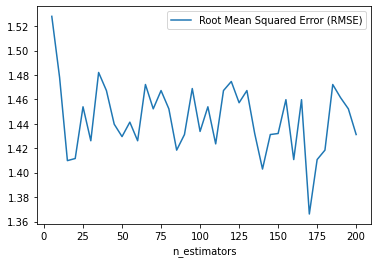

In [74]:
# Plot RMSE
evaluation_iso.plot(kind='line',x='n_estimators',y='Root Mean Squared Error (RMSE)')

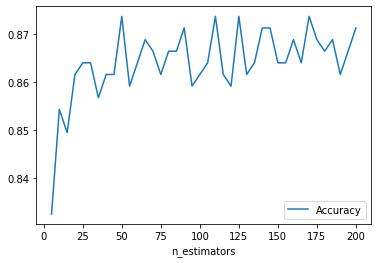

In [75]:
# Plot Accuracy
evaluation_iso.plot(kind='line',x='n_estimators',y='Accuracy')

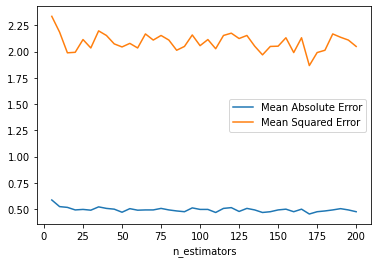

In [76]:
# Plot other Metrics
evaluation_iso.plot(kind='line',x='n_estimators',y=['Mean Absolute Error', 'Mean Squared Error'])

In [77]:
# Get row in dataframe where accuracy was the highest
best_model_iso = evaluation_iso.sort_values(by = "Accuracy", ascending = False).head(1)
best_model_iso

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
24,125.00,0.48,2.12,1.46,0.87


In [78]:
best_n_iso = int(best_model_iso['n_estimators'].iloc[0])
print("We saw best performace on a RandomForestClassifier with n_estimators = ", best_n_iso)

We saw best performace on a RandomForestClassifier with n_estimators =  125


In [79]:
# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=best_n_iso)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=125,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [80]:
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0,
       0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,

In [81]:
print('n_estimators = ', best_n_iso)
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators =  125
	Mean Absolute Error: 0.49271844660194175
	Mean Squared Error: 2.1092233009708736
	Root Mean Squared Error: 1.4523165291942641


In [82]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Final Accuray: ", accuracy_score(y_test, y_pred))

[[324   5   0]
 [ 39  33   0]
 [  9   2   0]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       329
           3       0.82      0.46      0.59        72
           7       0.00      0.00      0.00        11

    accuracy                           0.87       412
   macro avg       0.57      0.48      0.50       412
weighted avg       0.84      0.87      0.84       412

Final Accuray:  0.866504854368932


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
# Create DatFrame of Feature importance for our best model.
feature_importance3 = pd.DataFrame(rf.feature_importances_, X.columns)
feature_importance3.columns = ['importance3']
feature_importance3 = feature_importance3.sort_values(by = 'importance3', ascending = False)

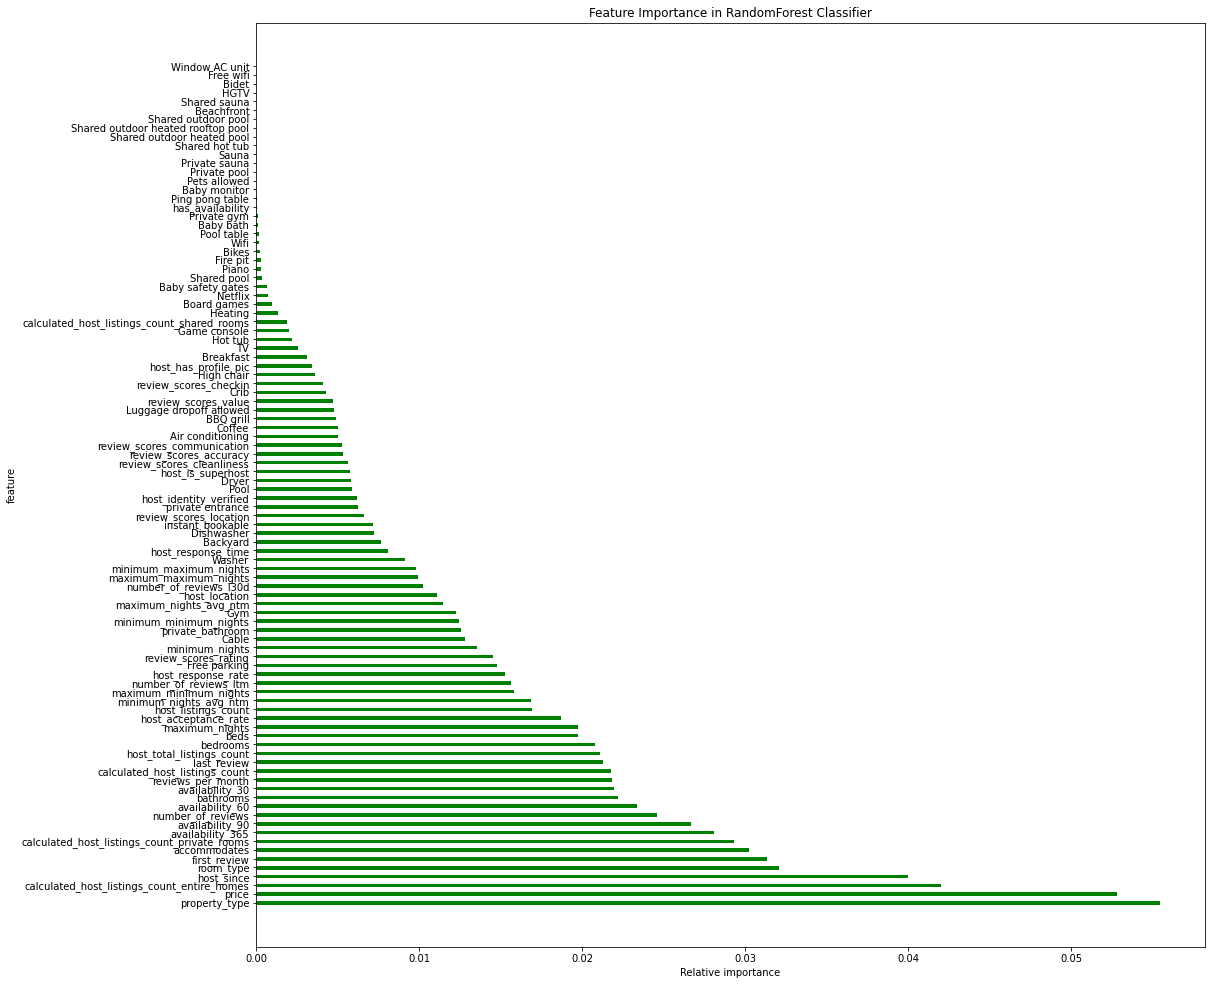

<Figure size 1224x1224 with 0 Axes>

In [84]:
col = feature_importance3.index
y = feature_importance3.importance3

# plot feature_importance
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature Importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(17,17))
fig.set_size_inches(17, 17, forward=True)

#### Feature Selection

To simplfy our logic, lets try to reduce the features on our last to ones with lower correlations.

In [85]:
selected_fields = listings_iso.corr()

# We already didn't see a very high correlation so we have to set our value pretty low
selected_fields = selected_fields[abs(selected_fields["neighbourhood_group"]) < .055]

selected_fields.sample(3)

,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,...,Bikes,Board games,Breakfast,Cable,Coffee,Crib,Dishwasher,Dryer,Fire pit,Free parking,Free wifi,Game console,Gym,HGTV,Heating,High chair,Hot tub,Luggage dropoff allowed,Netflix,Pets allowed,Piano,Ping pong table,Pool,Pool table,private entrance,Private gym,Private pool,Private sauna,Sauna,Shared hot tub,Shared outdoor heated pool,Shared outdoor heated rooftop pool,Shared outdoor pool,Shared pool,Shared sauna,TV,Washer,Wifi,Window AC unit,neighbourhood_group
host_response_time,0.14,0.19,0.01,-0.22,1.00,0.41,0.32,0.19,0.17,0.17,0.45,0.12,-0.07,-0.02,-0.01,0.00,-0.07,0.05,0.04,0.00,-0.00,-0.00,-0.19,-0.10,-0.20,-0.14,-0.06,-0.05,-0.14,-0.05,0.08,-0.05,-0.00,0.01,0.05,0.08,0.11,0.15,0.09,0.25,...,0.02,0.03,-0.09,-0.01,0.20,0.06,0.11,0.08,0.05,-0.11,nan,-0.04,0.05,nan,-0.17,0.04,-0.02,0.06,0.02,0.01,0.03,0.03,0.05,0.03,0.11,0.02,0.02,nan,-0.05,0.02,0.02,0.01,nan,0.02,-0.05,0.06,0.01,0.08,0.03,-0.03
Bikes,0.03,0.03,0.02,-0.04,0.02,-0.03,0.00,0.01,-0.02,-0.02,0.01,0.04,-0.01,0.04,0.06,0.11,0.10,-0.03,-0.02,-0.02,-0.00,-0.02,-0.02,-0.04,-0.02,-0.01,0.01,0.01,-0.01,0.01,0.00,0.04,0.05,0.04,0.03,0.03,0.05,0.01,0.02,0.01,...,1.00,0.09,0.02,-0.02,0.01,0.02,0.04,0.01,0.30,0.02,nan,0.06,-0.02,nan,0.02,-0.01,0.01,0.06,0.19,-0.00,0.21,-0.00,-0.04,0.29,-0.02,-0.00,-0.00,nan,-0.00,-0.00,-0.00,-0.00,nan,-0.01,-0.00,0.02,-0.01,0.00,-0.01,0.04
review_scores_checkin,-0.04,-0.07,-0.04,-0.03,-0.02,-0.00,-0.01,0.11,0.01,0.01,-0.03,-0.07,-0.00,-0.07,-0.05,0.00,-0.01,0.01,0.00,0.01,0.04,0.02,-0.04,-0.07,-0.04,-0.03,-0.02,-0.03,-0.03,-0.03,-0.00,-0.09,-0.09,-0.08,-0.04,0.09,0.06,0.07,-0.04,0.13,...,0.01,0.02,-0.02,0.03,0.04,0.05,-0.01,0.05,0.01,0.01,nan,0.02,-0.13,nan,-0.02,0.03,-0.03,0.05,0.01,0.01,-0.14,-0.02,-0.14,-0.01,0.01,0.01,0.01,nan,0.01,0.01,0.01,0.00,nan,0.01,0.01,-0.03,-0.04,-0.01,0.02,-0.02


In [86]:
# Reduce dataframe to only slected fields

# Keep dependent variable & price
kept_fields = set(np.append(selected_fields.index, ["neighbourhood_group", "price"]))
listings_iso = listings_iso[kept_fields]

print("Number of kept fields: ", len(kept_fields))

Number of kept fields:  59


In [87]:
# Dependent variable: neighbourhood_group
y = listings_iso['neighbourhood_group']

# Drop dependent variable and other variables that would tamper the results
X = listings_iso.drop('neighbourhood_group', axis=1)

In [88]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [89]:
# Do same process as before where we find best n_estimator in a for loop
evaluation_iso = pd.DataFrame({'n_estimators': [],
                           'Mean Absolute Error':[],
                           'Mean Squared Error':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'Accuracy':[]})

# Make for loop to graph RMSE & Accuracy for different n_estimators
for i in range(5, 201, 5):
    # Make Classifier & Fit
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    # append to evaluation data frame
    r = evaluation_iso.shape[0]
    evaluation_iso.loc[r] = [i,mae,mse,rmse,accuracy]

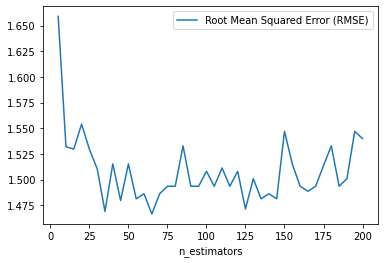

In [90]:
# Plot RMSE
evaluation_iso.plot(kind='line',x='n_estimators',y='Root Mean Squared Error (RMSE)')

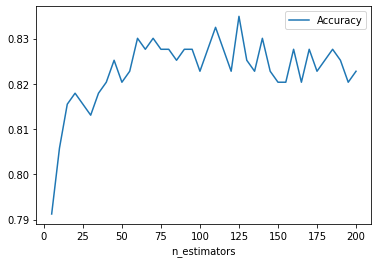

In [91]:
# Plot Accuracy
evaluation_iso.plot(kind='line',x='n_estimators',y='Accuracy')

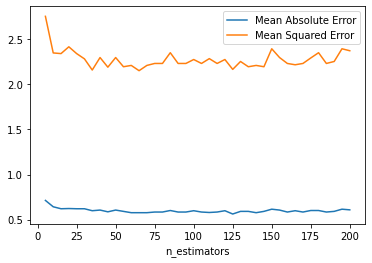

In [92]:
# Plot other Metrics
evaluation_iso.plot(kind='line',x='n_estimators',y=['Mean Absolute Error', 'Mean Squared Error'])

In [93]:
# Get row in dataframe where accuracy was the highest
best_model_iso = evaluation_iso.sort_values(by = "Accuracy", ascending = False).head(1)
best_model_iso

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
24,125.00,0.56,2.17,1.47,0.83


In [94]:
best_n_iso = int(best_model_iso['n_estimators'].iloc[0])
print("We saw best performace on a RandomForestClassifier with n_estimators = ", best_n_iso)

We saw best performace on a RandomForestClassifier with n_estimators =  125


In [95]:
# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=best_n_iso)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=125,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [96]:
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [97]:
print('n_estimators = ', best_n_iso)
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators =  125
	Mean Absolute Error: 0.5995145631067961
	Mean Squared Error: 2.2742718446601944
	Root Mean Squared Error: 1.5080689124374238


In [98]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Final Accuray: ", accuracy_score(y_test, y_pred))

[[320   6   0]
 [ 60  18   0]
 [  7   0   1]]
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       326
           3       0.75      0.23      0.35        78
           7       1.00      0.12      0.22         8

    accuracy                           0.82       412
   macro avg       0.86      0.45      0.49       412
weighted avg       0.82      0.82      0.78       412

Final Accuray:  0.8228155339805825


In [99]:
# Create DatFrame of Feature importance for our best model.
feature_importance4 = pd.DataFrame(rf.feature_importances_, X.columns)
feature_importance4.columns = ['importance4']
feature_importance4 = feature_importance4.sort_values(by = 'importance4', ascending = False)

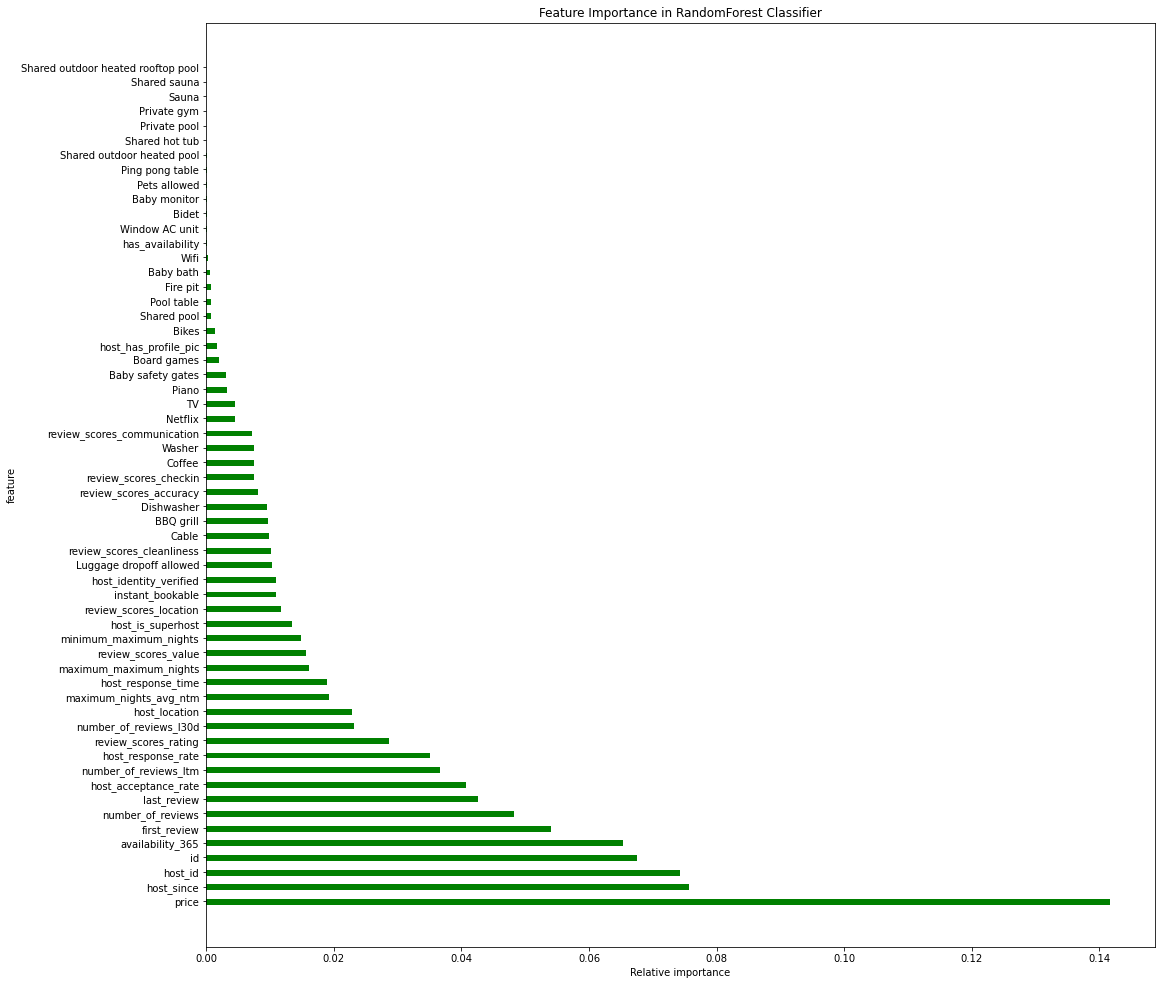

<Figure size 1224x1224 with 0 Axes>

In [100]:
col = feature_importance4.index
y = feature_importance4.importance4

# plot feature_importance
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature Importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(17,17))
fig.set_size_inches(17, 17, forward=True)

### Comparing Feature Importance

Lets compare the importance from all 4 models and see how they changed

In [101]:
all_feature_importance = feature_importance1.join(feature_importance2).join(feature_importance3).join(feature_importance4)

all_feature_importance.sample(3)

,importance1,importance2,importance3,importance4
number_of_reviews,0.03,0.03,0.02,0.05
maximum_minimum_nights,0.02,0.02,0.02,nan
Ping pong table,0.00,0.00,0.00,0.00


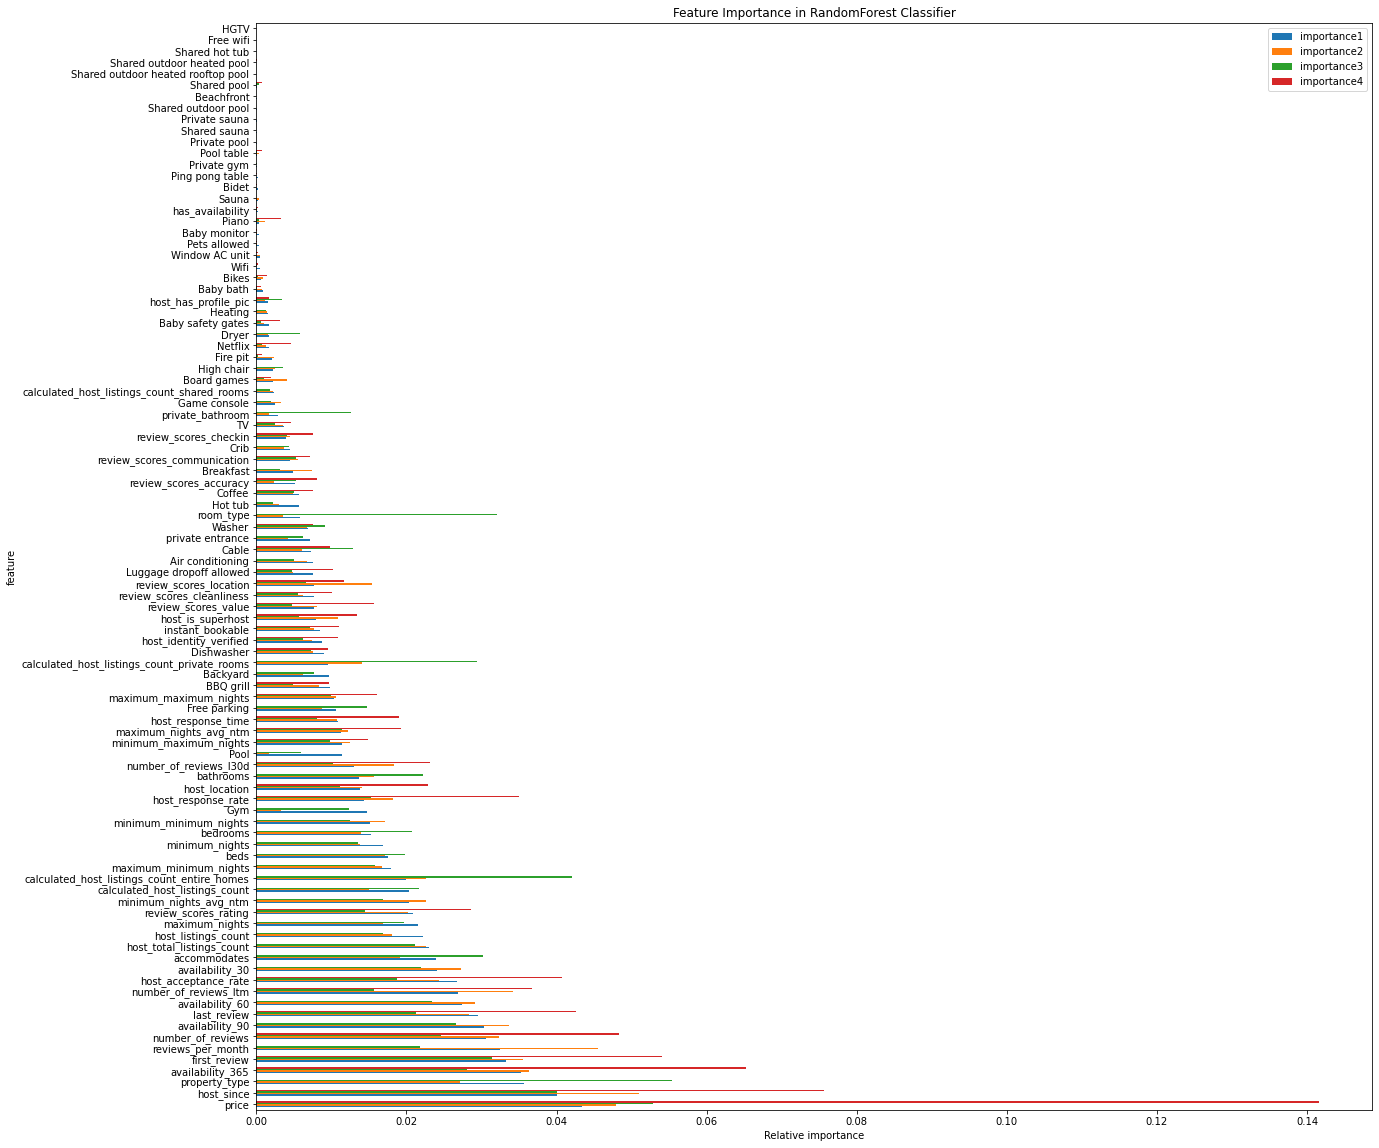

<Figure size 1440x1440 with 0 Axes>

In [102]:
all_feature_importance = all_feature_importance.sort_values(by = "importance1", ascending = False)

fig, ax = plt.subplots() 

all_feature_importance.plot(kind='barh', ax = ax)

plt.title('Feature Importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(20,20))
fig.set_size_inches(20, 20, forward=True)

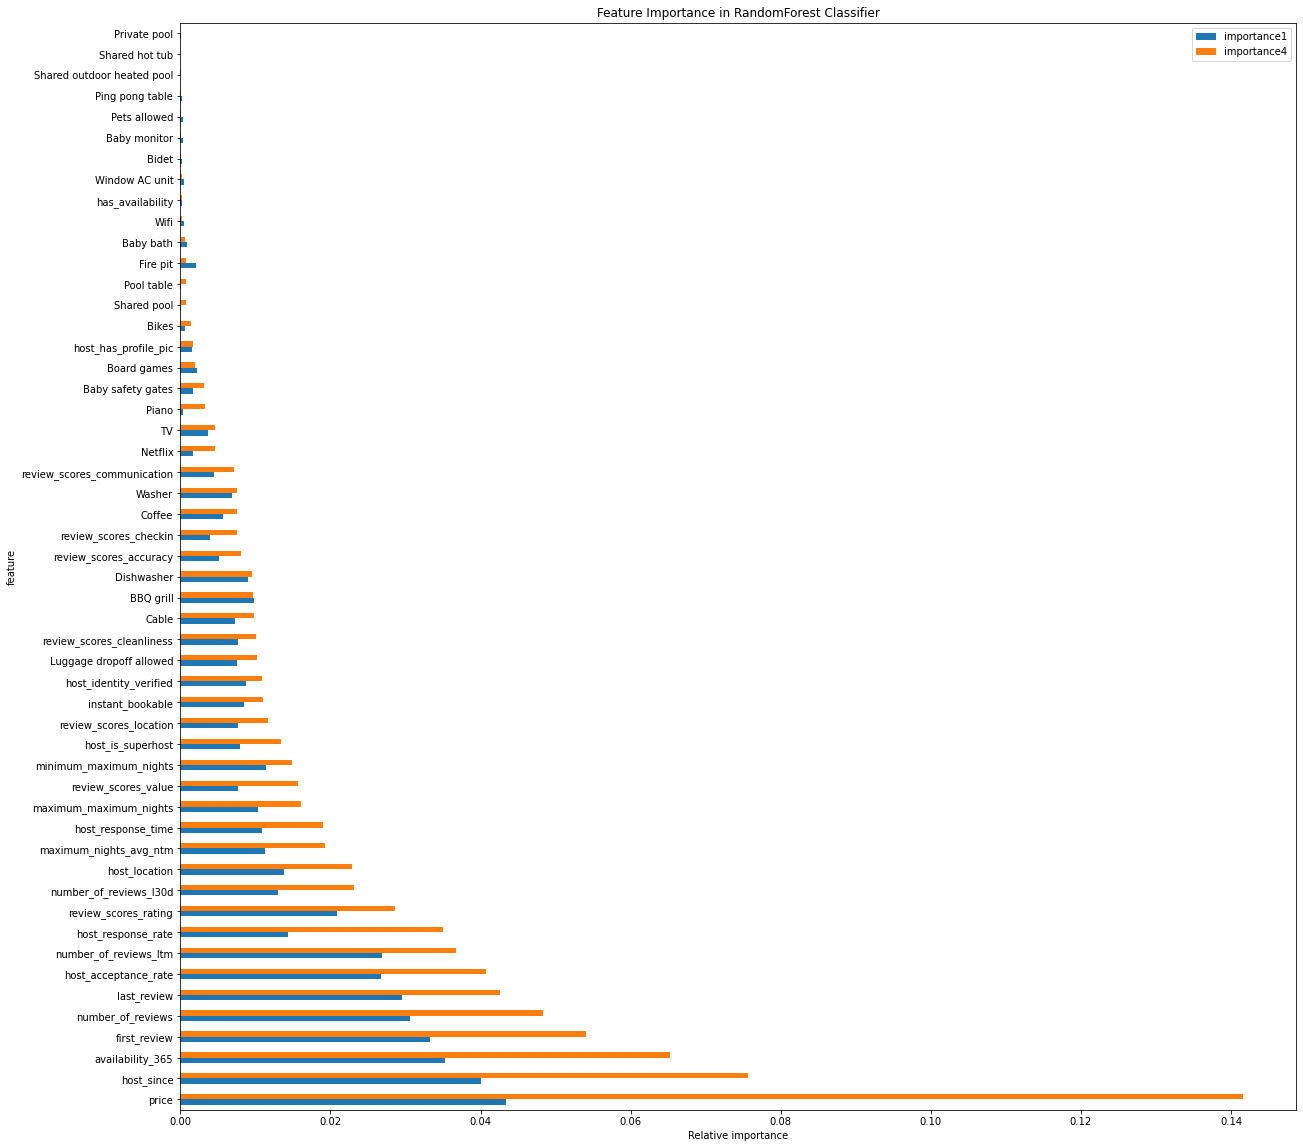

<Figure size 1440x1440 with 0 Axes>

In [103]:
# Now plot just the difference between our 1st & 4th model

# drop columns that weren't in 4th model
all_feature_importance = all_feature_importance.dropna()

# get columns where importance4 > 0
all_feature_importance = all_feature_importance[all_feature_importance["importance4"] > 0]

all_feature_importance = all_feature_importance.drop(['importance2', 'importance3'], axis = 1).sort_values(by = "importance4", ascending = False)

fig, ax = plt.subplots() 

all_feature_importance.plot(kind='barh', ax = ax)

plt.title('Feature Importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(20,20))
fig.set_size_inches(20, 20, forward=True)